## KMeans Clustering with EDA and JVA

The clustering analysis below explores how motor sensors used in the MMLA study predict qualitative, collaborative outcomes. Measures used are as follows:
1. EDA: Directional Agreement, Signal Matching, Pearsons' Correlations, Instantaneous Directional Matching
2. JVA: number of jva100 counts per second

Clustering analysis was performed by combining each EDA measure with JVA , the resulting analyses were:

1. DA+JVA
2. SM+JVA
3. PC+JVA
4. IDM+JVA


_The current document includes clustering with K=3, please see 'KMeans Clustering with EDA + JVA 4-10 Clusters Demo' for K in [4, 10]._ 

In [1]:
#import packages for clustering
import os
import math
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import sys
sys.path.insert(0, '../src/')
import cluster
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
sessions = pd.read_csv('../data_master/sessions.csv') #read sessions data
dependent = ['Sustaining Mutual Understanding ', 'Dialogue Management',
             'Information Pooling', 'Reaching Consensus', 'Task Division',
             'Time Managment', 'Technical Coordination', 'Reciprocal Interaction',
             'Individual Task Orientation', 'Collaboration', 'Task Performance',
             'Task Understanding', 'Improvement Over Time', 'Code quality',
             'Learning']

In [3]:
#generate master file for clustering
master = []
directory = '../group_combine_bySecond/' #get directory path
for csv in os.listdir(directory):
    file = pd.read_csv('../group_combine_bySecond/'+csv, index_col='Unnamed: 0')
    file['session'] = int(csv[:-21])
    cols = ['session','second','DA','PC','IDM','SM','jva100']
    fileNew = file.loc[:, cols]
    cols_fillnan = ['DA','PC','IDM','SM','jva100']
    fileNew[cols_fillnan] = fileNew[cols_fillnan].fillna(fileNew[cols_fillnan].mean(skipna=True)) #fill nans with mean for clustering purposes
    master.append(fileNew)

In [4]:
dfMaster = pd.concat(master, axis = 0) #concatenate data frames for master file
dfMaster = dfMaster.fillna(dfMaster.mean(skipna = True))

In [5]:
dfMaster.head()

,session,second,DA,PC,IDM,SM,jva100
0,38,1,0.220833,0.728505,0.257933,0.888684,0.0
1,38,2,0.220417,0.731814,0.257776,0.885079,1.0
2,38,3,0.218542,0.734432,0.256414,0.879169,15.0
3,38,4,0.218958,0.734211,0.255593,0.873995,21.0
4,38,5,0.220000,0.734423,0.255465,0.868285,11.0


In [6]:
#aggregate data
dfMaster = dfMaster.groupby(['session','second']).agg({
    'DA': np.mean,
    'PC': np.mean,
    'IDM': np.mean,
    'SM': np.mean,
    'jva100': np.mean,
})

dfMaster = dfMaster.reset_index().reset_index()
dfMaster.head()

,index,session,second,DA,PC,IDM,SM,jva100
0,0,1,1,0.358889,0.350320,0.167117,1.203445,19.0
1,1,1,2,0.357083,0.350938,0.165331,1.203421,22.0
2,2,1,3,0.358333,0.352759,0.164245,1.203627,12.0
3,3,1,4,0.358542,0.355855,0.164172,1.203845,4.0
4,4,1,5,0.357500,0.359739,0.164233,1.204056,8.0


In [7]:
scaleCols = ['DA','PC','IDM','SM','jva100'] #scale columns for clustering
scaler = StandardScaler()
scaler.fit(dfMaster[scaleCols])
dfMaster_scaled = dfMaster.copy() #copy original master data frame
dfMaster_scaled = dfMaster_scaled.loc[:, scaleCols]
dfMaster_scaled[scaleCols] = scaler.transform(dfMaster_scaled[scaleCols]) #scale transform cluster columns
dfMaster_scaled['index'] = np.arange(len(dfMaster_scaled)) #reappend index column to dfMaster_scaled for merging
dfMaster_scaled = dfMaster_scaled.rename(columns = {'DA':'DA_scaled', 'SM':'SM_scaled', 
                                                    'PC':'PC_scaled','IDM': 'IDM_scaled',
                                                    'jva100':'jva100_scaled'})
dfMaster = dfMaster.merge(dfMaster_scaled, on = 'index', how = 'outer') #merge scaled data with original data

In [8]:
dfMaster.to_csv('../data_master/EDA_JVA_MasterScaled.csv')

**Optimal K by Distortion Rate**

In [3]:
dfMaster = pd.read_csv("../data_master/EDA_JVA_MasterScaled.csv", index_col="Unnamed: 0")

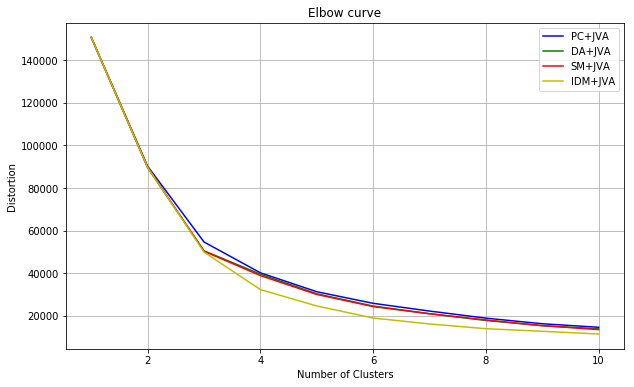

In [4]:
#find optimal number of clustering for KMeans
distortionPC = list() #cache list for distortion value
for n in range(1,11): #fit number of clusters in the range of 1 to 10
    kmeans_pc = KMeans(n_clusters=n, random_state=11)
    kmeans_pc.fit(dfMaster.loc[:, ['PC_scaled','jva100_scaled']]) 
    distortionPC.append(kmeans_pc.inertia_) #append distortion value to list

distortionDA = list()
for n in range(1,11):
    kmeans_da = KMeans(n_clusters=n, random_state=11)
    kmeans_da.fit(dfMaster.loc[:, ['DA_scaled','jva100_scaled']])
    distortionDA.append(kmeans_da.inertia_)
    
distortionSM = list()
for n in range(1,11):
    kmeans_sm = KMeans(n_clusters=n, random_state=11)
    kmeans_sm.fit(dfMaster.loc[:, ['SM_scaled','jva100_scaled']])
    distortionSM.append(kmeans_sm.inertia_)
    
distortionIDM = list()
for n in range(1,11):
    kmeans_idm = KMeans(n_clusters=n, random_state=11)
    kmeans_idm.fit(dfMaster.loc[:, ['IDM_scaled','jva100_scaled']])
    distortionIDM.append(kmeans_idm.inertia_)

#plot elbow curves 
fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), distortionPC, c = 'b', label = 'PC+JVA')
plt.plot(range(1, 11), distortionDA, c = 'g', label = 'DA+JVA')
plt.plot(range(1, 11), distortionSM, c = 'r', label = 'SM+JVA')
plt.plot(range(1, 11), distortionIDM, c = 'y', label = 'IDM+JVA')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.legend()
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [5]:
fig.savefig("optimalK_eda_jva.png")

**PC+JVA**

In [6]:
#cluster by K=3
dfMaster_pc3, centroids_pc3 = cluster.makeCluster(dfMaster, 3, 11, ['PC_scaled','jva100_scaled'])

In [11]:
dfMaster_pc3.to_csv('../data_visualization/PC_JVA_3.csv')

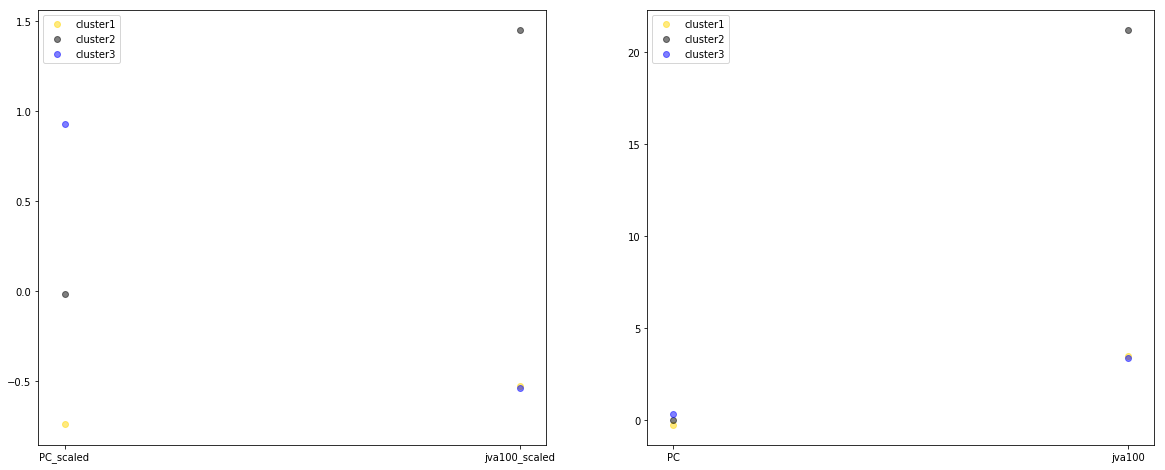

In [7]:
cluster.visualizeCluster(dfMaster_pc3, 3, ['PC_scaled','jva100_scaled'], ['PC','jva100'])

In [8]:
timeCluster_pc3 = cluster.timeCluster(dfMaster_pc3, 3)

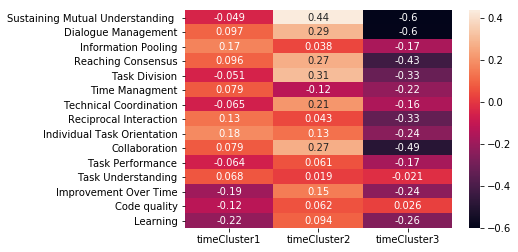

In [9]:
sessions_pc3 = sessions.merge(timeCluster_pc3, on = 'Session', how = 'outer') #merge data frames for correlation
time_pc3 = ['timeCluster1','timeCluster2','timeCluster3']

correlations_pc3 = sessions_pc3.corr()
ax = sns.heatmap(correlations_pc3.loc[dependent][time_pc3], annot=True)

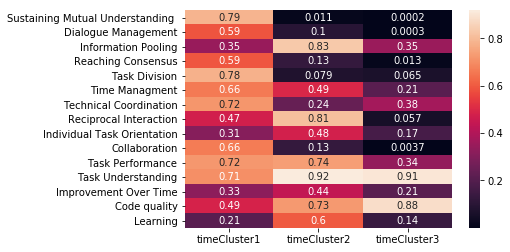

In [10]:
pvalues_pc3 = cluster.calculate_pvalues(sessions_pc3).astype(float)
ax = sns.heatmap(pvalues_pc3.loc[dependent][time_pc3], annot=True)

The above heatmap indicates that there are significant correlations between 

1. time spent in cluster 2 and sustaining mutual understanding (p = 0.011)
2. time spent in cluster 3 and sustaining mutual understanding (p = 0.0002)
3. time spent in cluster 3 and dialogue management (p = 0.0003)
4. time spent in cluster 3 and reaching consensus (p = 0.013)
5. time spent in cluster 3 and collaboration (p = 0.0037)

cluster 2 had the highest jva100 counts, whereas cluster 3 had the lowest jva100 counts(scaled) and the highest PC value.

**DA+JVA**

In [11]:
#cluster by K=3
dfMaster_da3, centroids_da3 = cluster.makeCluster(dfMaster, 3, 11, ['DA_scaled','jva100_scaled'])

In [17]:
dfMaster_da3.to_csv('../data_visualization/DA_JVA_3.csv')

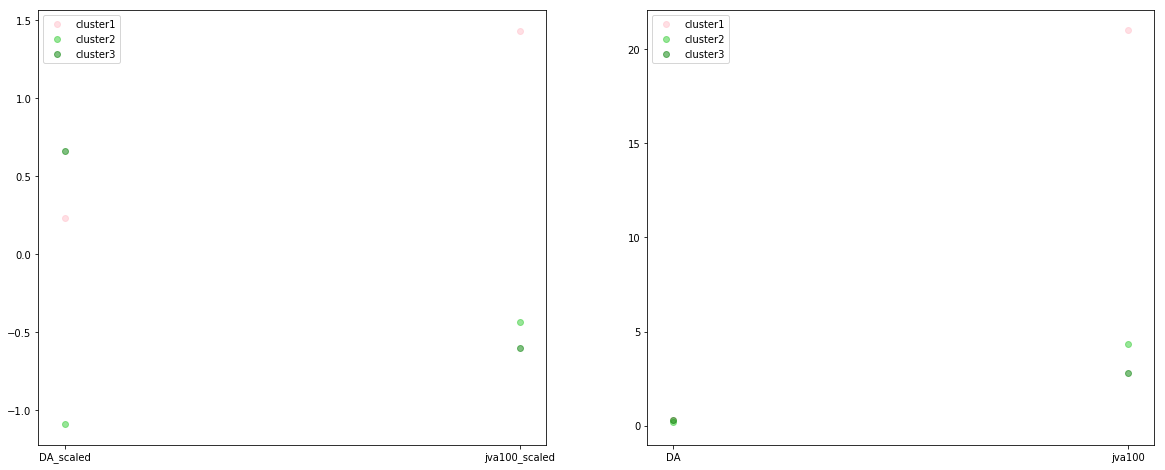

In [12]:
cluster.visualizeCluster(dfMaster_da3, 3, ['DA_scaled','jva100_scaled'], ['DA','jva100'])

In [13]:
timeCluster_da3 = cluster.timeCluster(dfMaster_da3, 3)

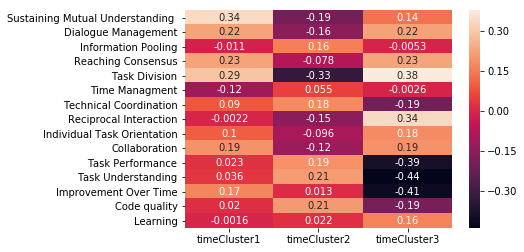

In [14]:
sessions_da3 = sessions.merge(timeCluster_da3, on = 'Session', how = 'outer') #merge data frames for correlation
time_da3 = ['timeCluster1','timeCluster2','timeCluster3']

correlations_da3 = sessions_da3.corr()
ax = sns.heatmap(correlations_da3.loc[dependent][time_da3], annot=True)

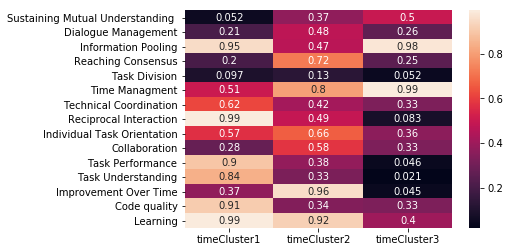

In [15]:
pvalues_da3 = cluster.calculate_pvalues(sessions_da3).astype(float)
ax = sns.heatmap(pvalues_da3.loc[dependent][time_da3], annot=True)

The heatmap above indicated that there is a significant correlation between time spent in cluster 3 and task understanding (p = 0.021). Cluster 3 had the highest DA value and lowest jva100 counts.


**SM+JVA**

In [16]:
#cluster by K=3
dfMaster_sm3, centroids_sm3 = cluster.makeCluster(dfMaster, 3, 11, ['SM_scaled','jva100_scaled'])

In [23]:
dfMaster_sm3.to_csv('../data_visualization/SM_JVA_3.csv')

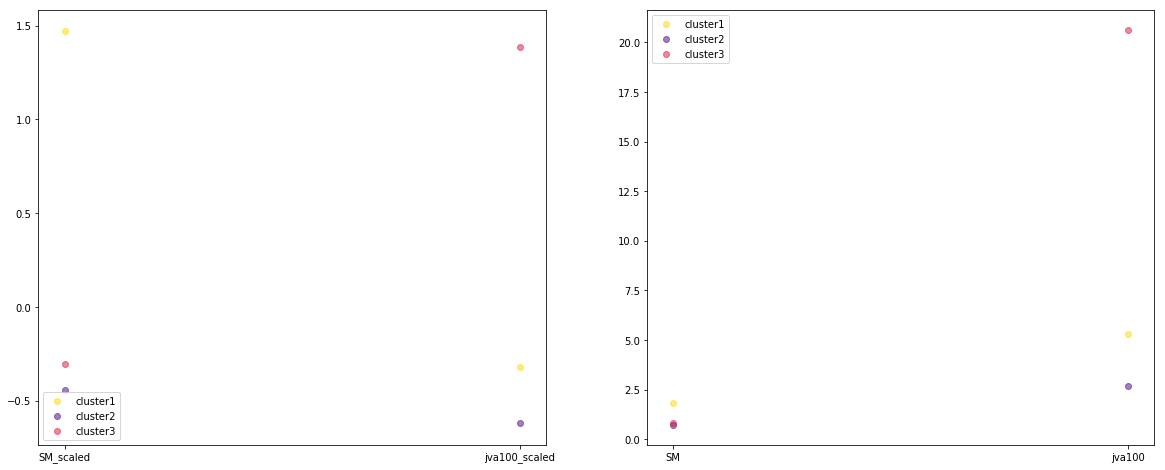

In [17]:
cluster.visualizeCluster(dfMaster_sm3, 3, ['SM_scaled','jva100_scaled'], ['SM','jva100'])

In [18]:
timeCluster_sm3 = cluster.timeCluster(dfMaster_sm3, 3)

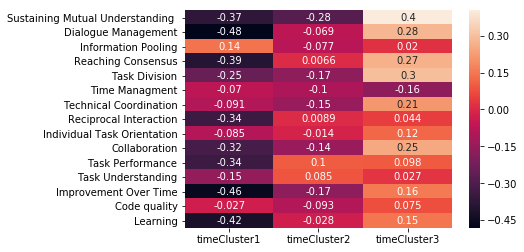

In [19]:
sessions_sm3 = sessions.merge(timeCluster_sm3, on = 'Session', how = 'outer') #merge data frames for correlation
time_sm3 = ['timeCluster1','timeCluster2','timeCluster3']

correlations_sm3 = sessions_sm3.corr()
ax = sns.heatmap(correlations_sm3.loc[dependent][time_sm3], annot=True)

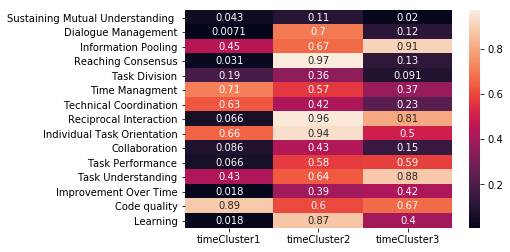

In [20]:
pvalues_sm3 = cluster.calculate_pvalues(sessions_sm3).astype(float)
ax = sns.heatmap(pvalues_sm3.loc[dependent][time_sm3], annot=True)

Significant correlations between:
1. time spent in cluster 1 and sustaining mutual understanding (p = 0.043)
2. time spent in cluster 1 and dialogue management (p = 0.0071)
3. time spent in cluster 1 and reaching consensus (p = 0.031)
4. time spent in cluster 1 and improvement over time (p = 0.018)
5. time spent in cluster 1 and learning (p = 0.018)
6. time spent in cluster 3 and sustaining mutual understanding (p = 0.02)

**this finding is the same when kinect data is added in!**

cluster 1  had the highest SM value, cluster 3 had the highest jva100 count.

**IDM+JVA**

In [21]:
#cluster by K=3
dfMaster_idm3, centroids_idm3 = cluster.makeCluster(dfMaster, 3, 11, ['IDM_scaled','jva100_scaled'])

In [29]:
dfMaster_idm3.to_csv('../data_visualization/IDM_JVA_3.csv')

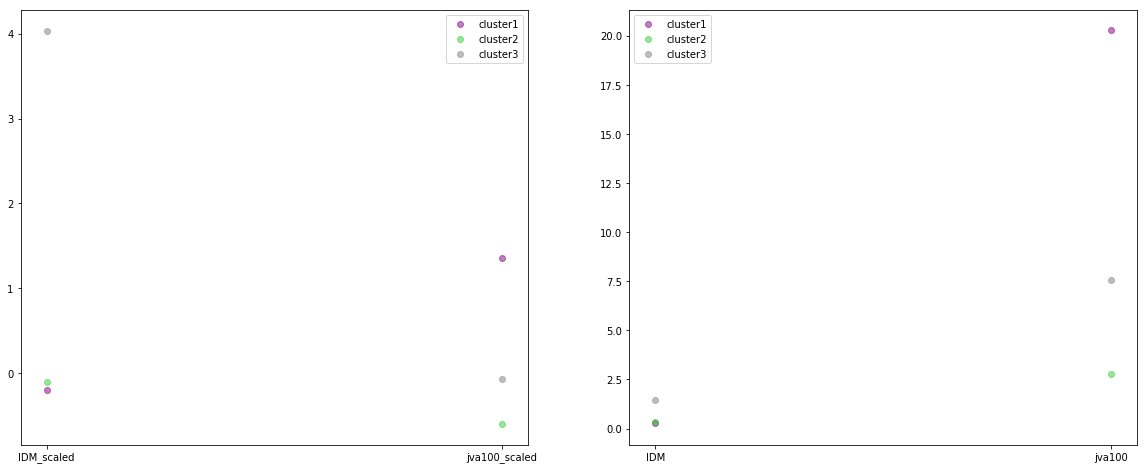

In [22]:
cluster.visualizeCluster(dfMaster_idm3, 3, ['IDM_scaled','jva100_scaled'], ['IDM','jva100'])

In [23]:
timeCluster_idm3 = cluster.timeCluster(dfMaster_idm3, 3)

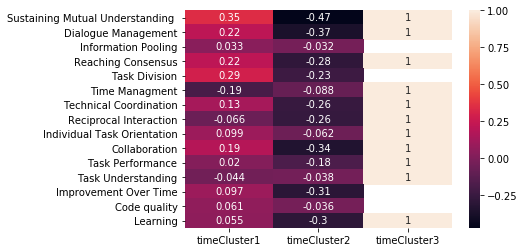

In [24]:
sessions_idm3 = sessions.merge(timeCluster_idm3, on = 'Session', how = 'outer') #merge data frames for correlation
time_idm3 = ['timeCluster1','timeCluster2','timeCluster3']

correlations_idm3 = sessions_idm3.corr()
ax = sns.heatmap(correlations_idm3.loc[dependent][time_idm3], annot=True)

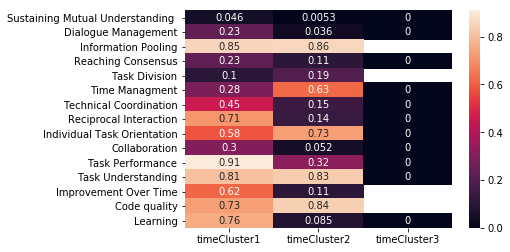

In [25]:
pvalues_idm3 = cluster.calculate_pvalues(sessions_idm3).astype(float)
ax = sns.heatmap(pvalues_idm3.loc[dependent][time_idm3], annot=True)

Significant correlations between:

1. time spent in cluster 2 and sustaining mutual understanding (p = 0.0053)
2. time spent in cluster 2 and dialogue management (p = 0.036)
3. time spent in cluster 3 and everything except for information pooling, task division, improvement over time and code quality

cluster 2 had the lowest jva count, cluster 3 had the highest jva and lowest idm.